In [1]:
## Import Packages
import numpy as np
import _pickle as pk
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import os 

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=40,**{'family':'sans-serif','sans-serif':['Arial']})
mpl.rcParams['hatch.linewidth'] = 1
%matplotlib inline

In [2]:
Source = '/Volumes/eSSD0/Papers/GMD_CanESM_p1/Data/'
mods = ['CanESM2','CanESM5_p2']

lat = np.linspace(-87.864,87.864,64)
lon = np.linspace(0,357.1875,128)

landmask_source = '/Volumes/eSSD0/Papers/GMD_CanESM_p2/Analysis/Control/'
CanESM5 = pk.load(open(landmask_source+'results/CanESM5_CCF_picon.pi','rb'))
landmask = np.isnan(CanESM5['TADV'][0,:,:])
landvalid = np.isfinite(CanESM5['TADV'][0,:,:])
landmask_ext = np.tile(landmask[None,:,:],(150,1,1))

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat[None,:,None],(lon.size,1,150)).T
coslat_subtrop = coslat[:,10:54,:]
coslat_trop = coslat[:,21:43,:]

EIS_time = {}
EIS_picon = {}
lowcld = {}
lowcld_un = {}
for m in range(2):
    EIS_time[mods[m]] = pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_EIS_x4_TmSrs.pi','rb'))
    EIS_picon[mods[m]] = np.nanmean(pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_EIS_picon_TmSrs.pi','rb')),axis=0)

    lowcld[mods[m]] = pk.load(open(Source+mods[m]+'/Fluxes/'+mods[m]+'_TrCLsw_FLUX_FB_MZdecomp_Grid.pi','rb'))['Amount']['Low']
    lowcld_un[mods[m]] = pk.load(open(Source+mods[m]+'/Fluxes/'+mods[m]+'_TrCLsw_FLUX_FB_SRdecomp_Grid.pi','rb'))['Low_unobscured']

cloud_delta = lowcld['CanESM5_p2']-lowcld['CanESM2']
cloud_delta[landmask] = np.nan
cloud_delta_plot = np.concatenate((cloud_delta[:,64:],cloud_delta[:,:64]),axis=1)
cloud_delta_plot,lon_cyc = add_cyclic_point(cloud_delta_plot,lon)

cloud_un_delta = lowcld_un['CanESM5_p2']-lowcld_un['CanESM2']
cloud_un_delta[landmask] = np.nan
cloud_un_delta_plot = np.concatenate((cloud_un_delta[:,64:],cloud_un_delta[:,:64]),axis=1)
cloud_un_delta_plot,lon_cyc = add_cyclic_point(cloud_un_delta_plot,lon)

cloud_mask = cloud_un_delta<0.21
cloud_mask[landmask] = np.nan
cloud_mask_plot = np.concatenate((cloud_mask[:,64:],cloud_mask[:,:64]),axis=1)
cloud_mask_plot,lon_cyc = add_cyclic_point(cloud_mask_plot,lon)

In [11]:
tas = dict()
for mods in EIS_time.keys():
    tas[mods] = pk.load(open(Source+\
    mods+'/ERF/'+mods+'_TAS_GAM.pi','rb'))

    tas[mods] = np.mean(tas[mods][130:])

In [15]:
EIS_resp = {}
for models in EIS_time.keys():
    EIS_time[models][landmask_ext] = np.nan
    EIS_picon[models][landmask] = np.nan
    EIS_resp[models] = (np.ma.mean(np.ma.masked_invalid(EIS_time[models])[130:],axis=0)-EIS_picon[models])/tas[models]
    EIS_picon[models] = np.ma.masked_invalid(EIS_picon[models])

In [16]:
EIS_picon_plot = {}
EIS_resp_plot = {}
for mods in EIS_time.keys():

    EIS_picon_plot[mods] = np.concatenate((EIS_picon[mods][:,64:],EIS_picon[mods][:,0:64]),axis=1)
    EIS_picon_plot[mods],lon_cyc = add_cyclic_point(EIS_picon_plot[mods],lon)

    EIS_resp_plot[mods] = np.concatenate((EIS_resp[mods][:,64:],EIS_resp[mods][:,0:64]),axis=1)
    EIS_resp_plot[mods],lon_cyc = add_cyclic_point(EIS_resp_plot[mods],lon)


delta_picon_plot = EIS_picon_plot['CanESM5_p2']-EIS_picon_plot['CanESM2']
delta_picon_plot = np.ma.masked_invalid(delta_picon_plot)
delta_resp_plot = EIS_resp_plot['CanESM5_p2']-EIS_resp_plot['CanESM2']
delta_resp_plot = np.ma.masked_where(delta_resp_plot == 0,delta_resp_plot)

EIS_resp_plot['CanESM2'] = np.ma.masked_where(EIS_resp_plot['CanESM2']==0,EIS_resp_plot['CanESM2'])

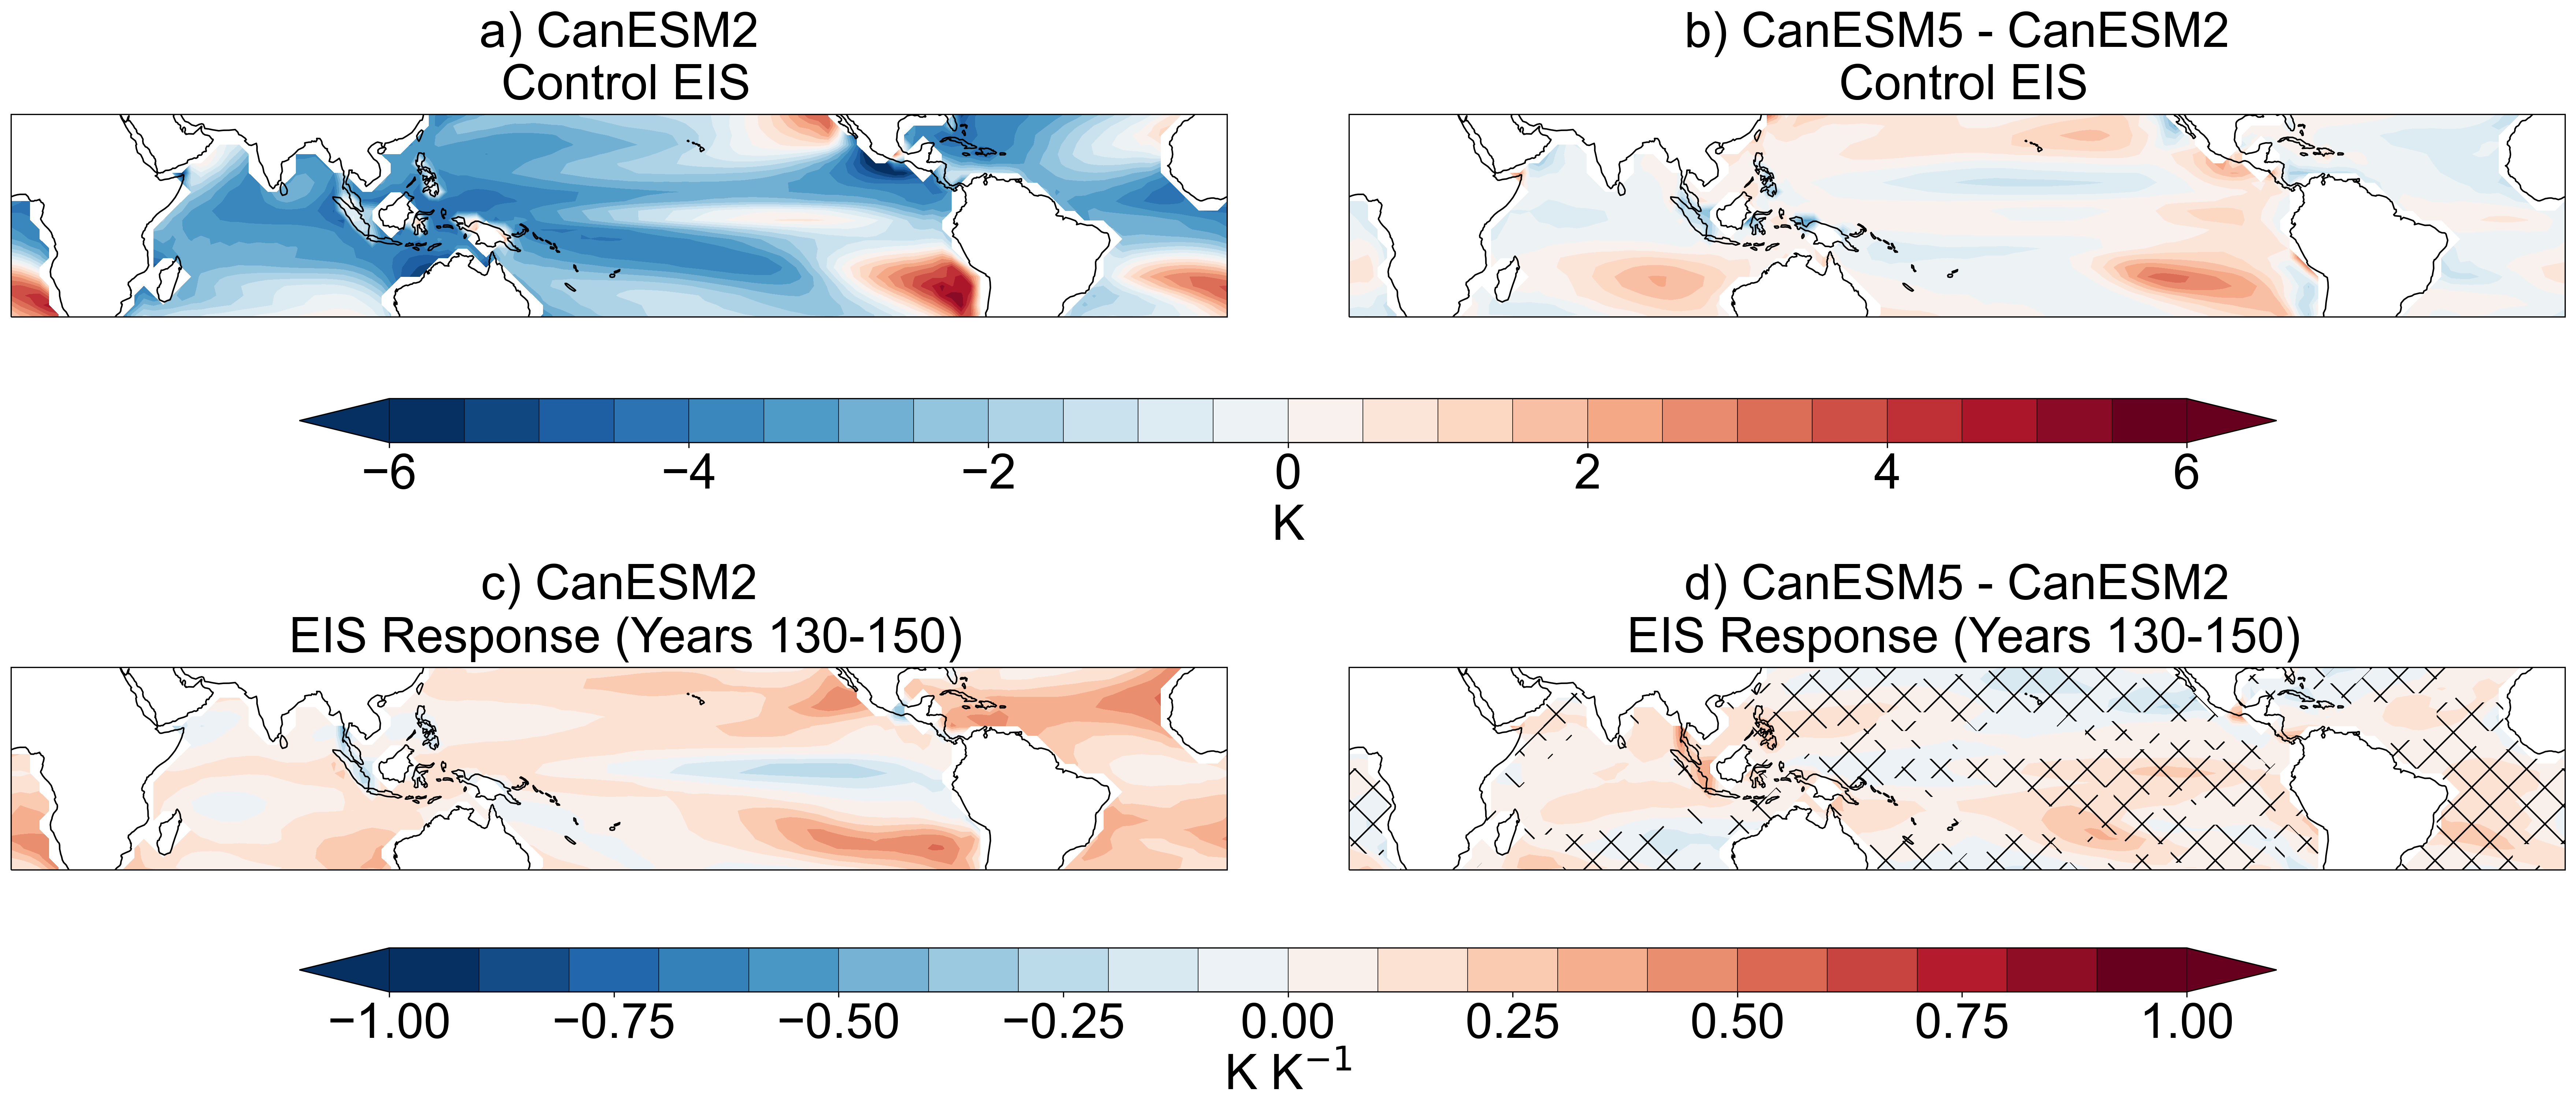

In [36]:
bounds = np.arange(-6,6.1,0.5)
bounds_ticks = np.arange(-6,6.1,2)
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

bounds_resp = np.arange(-1,1.1,0.1)
bounds_resp_ticks = np.arange(-1,1.1,0.25)
cmap = plt.cm.RdBu_r
norm_resp = mpl.colors.BoundaryNorm(bounds_resp, cmap.N)

fig = plt.figure(figsize=(30,20),dpi=300)
ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-180, 30, -30, 30], crs=ccrs.PlateCarree())
ax.set_title('a) CanESM2\n Control EIS',fontsize=32,pad=10)
im = ax.contourf(lon_cyc,lat,EIS_picon_plot['CanESM2'],bounds,cmap=cmap,norm=norm,extend='both')
ax.coastlines()

ax1 = plt.subplot(2,2,2,projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([-180, 30, -30, 30], crs=ccrs.PlateCarree())
ax1.set_title('b) CanESM5 - CanESM2\n Control EIS',fontsize=32,pad=10)
im1 = ax1.contourf(lon_cyc,lat,delta_picon_plot,bounds,cmap=cmap,norm=norm,extend='both')
ax1.coastlines()

ax2 = plt.subplot(2,2,3,projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([-180, 30, -30, 30], crs=ccrs.PlateCarree())
ax2.set_title('c) CanESM2\n EIS Response (Years 130-150)',fontsize=32,pad=10)
im2 = ax2.contourf(lon_cyc,lat,EIS_resp_plot['CanESM2'],bounds_resp,cmap=cmap,norm=norm_resp,extend='both')
ax2.coastlines()

ax3 = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax3.set_extent([-180, 30, -30, 30], crs=ccrs.PlateCarree())
ax3.set_title('d) CanESM5 - CanESM2\n EIS Response (Years 130-150)',fontsize=32,pad=10)
im3 = ax3.contourf(lon_cyc,lat,delta_resp_plot,bounds_resp,cmap=cmap,norm=norm_resp,extend='both')
im3_h = ax3.contourf(lon_cyc,lat,cloud_mask_plot,1,colors='none',hatches=['x',''])
ax3.coastlines()

plt.subplots_adjust(hspace=-0.5,wspace=0.1)

cax = fig.add_axes([0.2125, 0.525, 0.6, 0.02])
cbar = plt.colorbar(im,cax=cax,ticks=bounds_ticks,drawedges=True,orientation='horizontal')
cbar.set_label('K',fontsize=32)
cbar.ax.tick_params(labelsize=32)

cax1 = fig.add_axes([0.2125, 0.275, 0.6, 0.02])
cbar1 = plt.colorbar(im3,cax=cax1,ticks=bounds_resp_ticks,drawedges=True,orientation='horizontal')
cbar1.set_label('K K$^{-1}$',fontsize=32)
cbar1.ax.tick_params(labelsize=32)

plt.savefig('EIS_Response.png',bbox_inches='tight')